<a href="https://colab.research.google.com/github/komal65/API-Axios-Practice/blob/master/DL_Mini_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jangedoo/utkface-new")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/utkface-new


In [3]:
import os

dataset_path = "/kaggle/input/utkface-new"

# List first 10 files
file_list = os.listdir(dataset_path)
print("Sample files:", file_list[:10])


Sample files: ['UTKFace', 'utkface_aligned_cropped', 'crop_part1']


In [4]:
import os
import tensorflow as tf

# Path to dataset (downloaded using kagglehub)
dataset_path = "/kaggle/input/utkface-new"
image_folder = os.path.join(dataset_path, "UTKFace")


In [5]:
print("Sample image files:", os.listdir(image_folder)[:5])


Sample image files: ['26_0_2_20170104023102422.jpg.chip.jpg', '22_1_1_20170112233644761.jpg.chip.jpg', '21_1_3_20170105003215901.jpg.chip.jpg', '28_0_0_20170117180555824.jpg.chip.jpg', '17_1_4_20170103222931966.jpg.chip.jpg']


In [6]:
def extract_labels(filename):
    parts = tf.strings.split(filename, '_')
    age = tf.strings.to_number(parts[0], tf.int32)
    gender = tf.strings.to_number(parts[1], tf.int32)
    return age, gender

def process_path(file_path):
    filename = tf.strings.split(file_path, os.sep)[-1]
    age, gender = extract_labels(filename)

    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [100, 100])
    image = tf.cast(image, tf.float32) / 255.0

    return image, {'age_output': age, 'gender_output': tf.cast(gender, tf.float32)}


In [7]:
# Load all file paths
all_files = tf.data.Dataset.list_files(image_folder + "/*.jpg", shuffle=True)
file_count = sum(1 for _ in all_files)
train_size = int(0.8 * file_count)

# Recreate because the dataset is consumed during iteration
all_files = tf.data.Dataset.list_files(image_folder + "/*.jpg", shuffle=True)

# Prepare train and validation datasets
train_ds = all_files.take(train_size).map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = all_files.skip(train_size).map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)


In [8]:
from tensorflow.keras import layers, Model

input_layer = layers.Input(shape=(100, 100, 3))

x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

age_output = layers.Dense(1, name='age_output')(x)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)

model = Model(inputs=input_layer, outputs=[age_output, gender_output])

model.compile(
    optimizer='adam',
    loss={
        'age_output': 'mse',
        'gender_output': 'binary_crossentropy'
    },
    metrics={
        'age_output': 'mae',
        'gender_output': 'accuracy'
    }
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 98, 98,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 49, 49,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 47, 47,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 23, 23,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 33856)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  4,333,696 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        129 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        129 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,353,346 (16.61 MB)

 Trainable params: 4,353,346 (16.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 90s 143ms/step - age_output_loss: 353.4973 - age_output_mae: 14.0476 - gender_output_accuracy: 0.6316 - gender_output_loss: 0.6614 - loss: 354.1585 - val_age_output_loss: 204.5979 - val_age_output_mae: 11.4188 - val_gender_output_accuracy: 0.6160 - val_gender_output_loss: 0.6875 - val_loss: 205.7995
Epoch 2/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 87s 55ms/step - age_output_loss: 154.6683 - age_output_mae: 9.3791 - gender_output_accuracy: 0.7834 - gender_output_loss: 0.4781 - loss: 155.1464 - val_age_output_loss: 115.4370 - val_age_output_mae: 8.0334 - val_gender_output_accuracy: 0.8163 - val_gender_output_loss: 0.4250 - val_loss: 116.1234
Epoch 3/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - age_output_loss: 114.9516 - age_output_mae: 7.9463 - gender_output_accuracy: 0.8028 - gender_output_loss: 0.4304 - loss: 115.3818 - val_age_output_loss: 93.8688 - val_age_output_mae: 7.2524 - val_gender_output_accuracy: 0.8347 - val_gender_output_loss: 0.3788 - val

In [10]:
model.save("gender_age_model.keras")


In [11]:
# Example inference on validation sample
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    print("Predicted age:", preds[0][0])
    print("Predicted gender (0=Male, 1=Female):", preds[1][0])
    break


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
Predicted age: [7.2341866]
Predicted gender (0=Male, 1=Female): [0.97147995]


Saving 1.png to 1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


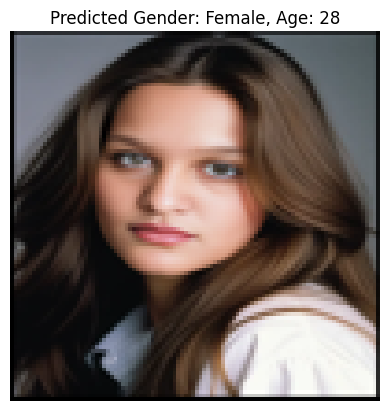

In [13]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Upload image
uploaded = files.upload()

# Load the image
for filename in uploaded.keys():
    img_path = filename
    image = Image.open(img_path).convert('RGB')
    image = image.resize((100, 100))
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    # Predict
    age_pred, gender_pred = model.predict(image_array)
    age_pred = int(age_pred[0][0])
    gender_pred = "Female" if gender_pred[0][0] > 0.5 else "Male"

    # Show results
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted Gender: {gender_pred}, Age: {age_pred}")
    plt.show()


In [14]:
!pip install gradio --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 127.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.4 MB/s eta 0:00:00


In [15]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the trained model
model = tf.keras.models.load_model("gender_age_model.keras")

# Prediction function
def predict_age_gender(image):
    image = image.convert("RGB").resize((100, 100))
    img_array = np.array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    age_pred, gender_pred = model.predict(img_array)
    predicted_age = int(age_pred[0][0])
    predicted_gender = "Female" if gender_pred[0][0] > 0.5 else "Male"

    return f"Predicted Gender: {predicted_gender}, Predicted Age: {predicted_age}"


In [16]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the model
model = tf.keras.models.load_model("gender_age_model.keras")

# Prediction logic
def predict_age_gender(image):
    if image is None:
        return "No image provided."

    image = image.convert("RGB").resize((100, 100))
    img_array = np.array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    age_pred, gender_pred = model.predict(img_array)
    predicted_age = int(age_pred[0][0])
    predicted_gender = "Female" if gender_pred[0][0] > 0.5 else "Male"

    return f"Predicted Gender: {predicted_gender}, Predicted Age: {predicted_age}"


In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("## 🎯 Gender and Age Detection")
    gr.Markdown("Upload or capture an image to predict gender and age.")

    with gr.Tab("📸 Webcam"):
        webcam_input = gr.Image(type="pil", label="Webcam Capture", sources=["webcam"])
        webcam_output = gr.Textbox(label="Prediction")
        webcam_button = gr.Button("Predict from Webcam")
        webcam_button.click(fn=predict_age_gender, inputs=webcam_input, outputs=webcam_output)

    with gr.Tab("📁 Upload"):
        upload_input = gr.Image(type="pil", label="Upload Image", sources=["upload"])
        upload_output = gr.Textbox(label="Prediction")
        upload_button = gr.Button("Predict from Upload")
        upload_button.click(fn=predict_age_gender, inputs=upload_input, outputs=upload_output)

demo.launch(debug=True)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://2b50dfc6ce476941e1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [ ]:
!pip install mtcnn lz4 --quiet


In [ ]:
from mtcnn.mtcnn import MTCNN
detector = MTCNN()


In [ ]:
detector = MTCNN()

def detect_and_predict(image):
    if image is None:
        return None, "No image provided."

    # Convert to array
    img_array = np.array(image)

    # Detect faces
    faces = detector.detect_faces(img_array)

    if not faces:
        return image, "No face detected."

    for face in faces:
        x, y, w, h = face["box"]
        face_img = img_array[y:y+h, x:x+w]

        # Preprocess face for model
        face_pil = Image.fromarray(face_img).resize((100, 100))
        face_array = np.array(face_pil) / 255.0
        face_array = np.expand_dims(face_array, axis=0)

        # Predict
        age_pred, gender_pred = model.predict(face_array)
        predicted_age = int(age_pred[0][0])
        predicted_gender = "Female" if gender_pred[0][0] > 0.5 else "Male"

        # Annotate image
        cv2.rectangle(img_array, (x, y), (x + w, y + h), (0, 255, 0), 2)
        label = f"{predicted_gender}, {predicted_age}"
        cv2.putText(img_array, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.8, (0, 255, 0), 2)

    annotated_img = Image.fromarray(img_array)
    return annotated_img, label


In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("## 🧠 Gender & Age Detection with Face Box (MTCNN)")
    gr.Markdown("Upload or capture an image. Model will detect face, draw green box, and display prediction.")

    with gr.Tab("📸 Webcam"):
        webcam_input = gr.Image(type="pil", label="Webcam Capture", sources=["webcam"])
        webcam_image = gr.Image(label="Result with Annotation")
        webcam_output = gr.Textbox(label="Prediction")
        webcam_button = gr.Button("Detect & Predict")
        webcam_button.click(fn=detect_and_predict, inputs=webcam_input, outputs=[webcam_image, webcam_output])

    with gr.Tab("📁 Upload"):
        upload_input = gr.Image(type="pil", label="Upload Image", sources=["upload"])
        upload_image = gr.Image(label="Result with Annotation")
        upload_output = gr.Textbox(label="Prediction")
        upload_button = gr.Button("Detect & Predict")
        upload_button.click(fn=detect_and_predict, inputs=upload_input, outputs=[upload_image, upload_output])

demo.launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://115dbcc02045674d2a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://115dbcc02045674d2a.gradio.live
